In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(9,6)})

In [3]:
events_data = pd.read_csv("event_data_train.csv")
submissions_data = pd.read_csv("submissions_data_train.csv")

In [4]:
#events_data.head(10)
submissions_data.head(10)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853
7,31977,1434347371,correct,15853
8,31978,1434349981,correct,15853
9,31979,1434446091,correct,15853


In [5]:
events_data["date"] = pd.to_datetime(events_data.timestamp, unit="s")
submissions_data["date"] = pd.to_datetime(submissions_data.timestamp, unit="s")

In [6]:
events_data["day"] = events_data.date.dt.date
submissions_data["day"] = submissions_data.date.dt.date

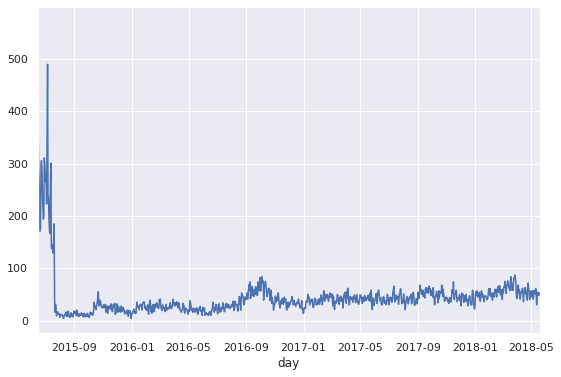

In [7]:
#events_data.groupby("day").user_id.nunique().plot()
submissions_data.groupby("day").user_id.nunique().plot()

In [8]:
#events_data[events_data.action == "passed"] \
#    .groupby("user_id", as_index=False) \
#    .aggregate({ "step_id":"count"}) \
#    .rename(columns={"step_id":"passed_steps"}) \
#    .passed_steps.hist()

In [9]:
users_events_data = events_data.pivot_table(index="user_id",
                        columns="action",
                        values="step_id", 
                        aggfunc="count",
                        fill_value=0).reset_index()

In [10]:
users_scores = submissions_data.pivot_table(index="user_id",
                        columns="submission_status",
                        values="step_id", 
                        aggfunc="count",
                        fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [11]:
gap_data = events_data[["user_id","day","timestamp"]] \
    .drop_duplicates(subset=["user_id","day"]) \
    .groupby("user_id")["timestamp"] \
    .apply(list) \
    .apply(np.diff) \
    .values

In [12]:
gap_data = pd.Series(np.concatenate(gap_data,axis=0))

In [13]:
gap_data = gap_data / (24 * 60 * 60)

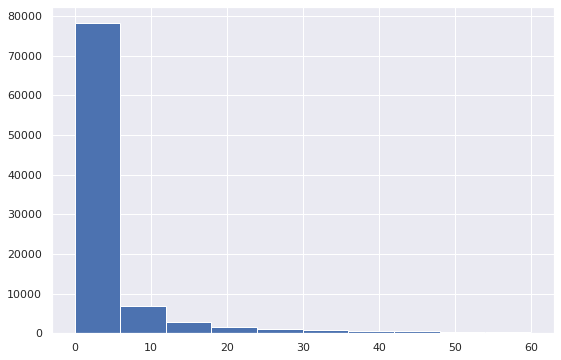

In [14]:
gap_data[gap_data < 60].hist()

In [15]:
gap_data.quantile(0.90) / (24 * 60 * 60)

0.00021210642789780559

In [16]:
users_data = events_data.groupby("user_id", as_index=False).aggregate({
    "timestamp":"max"
}).rename(columns={
    "timestamp":"last_timestamp"
})

In [18]:
users_data["is_gone_user"] = now - users_data["last_timestamp"] > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [17]:
now = 1526772811
drop_out_threshold = 2592000

In [19]:
users_data = users_data.merge(users_scores, how="outer")

In [20]:
users_data = users_data.fillna(0)

In [21]:
users_data = users_data.merge(users_events_data, how="outer")

In [22]:
users_days = events_data.groupby("user_id") \
    .day \
    .nunique() \
    .to_frame() \
    .reset_index()

In [23]:
users_data = users_data.merge(users_days, how="outer")

In [24]:
users_data["passed_course"] = users_data.passed > 170

In [25]:
users_data.to_csv("users_data.csv")

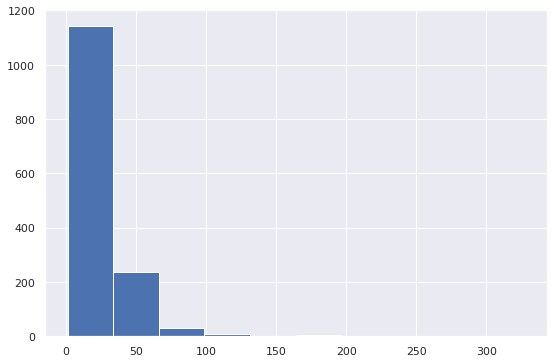

In [26]:
users_data[users_data["passed_course"]].day.hist()

In [27]:
user_min_time = events_data.groupby("user_id", as_index=False) \
    .aggregate({
    "timestamp":"min"
    }) \
    .rename({
    "timestamp": "min_timestamp"
    }, axis=1)

In [28]:
users_data = users_data.merge(user_min_time, how="outer")

In [29]:
events_data["user_time"] = events_data["user_id"].map(str) + "_" + events_data["timestamp"].map(str)

In [30]:
learning_time_threshold = 3 *24*60*60

In [31]:
user_learning_time_threshold = user_min_time["user_id"].map(str) + "_" + (user_min_time["min_timestamp"] + learning_time_threshold).map(str)

In [32]:
user_min_time["user_learning_time_threshold"] = user_learning_time_threshold

In [33]:
events_data = events_data.merge(user_min_time[["user_id", "user_learning_time_threshold"]], how="outer")

In [34]:
events_data_train = events_data[events_data["user_time"] <= events_data["user_learning_time_threshold"]]

In [35]:
you_shall_not_pass = submissions_data[["step_id","timestamp","submission_status","user_id"]] \
    .drop_duplicates(subset=["user_id"])

In [36]:
you_shall_not_pass = submissions_data[submissions_data.submission_status == "wrong"].step_id.value_counts()

In [37]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [42]:
X = submissions_data_train.groupby("user_id").day.nunique().to_frame().reset_index() \
    .rename(columns={
    "day":"days"
    })

In [43]:
steps_tries = submissions_data_train.groupby("user_id").step_id.nunique().to_frame().reset_index() \
    .rename(columns={
    "step_id":"steps_tries"
    })

In [44]:
X = X.merge(steps_tries, on="user_id", how="outer")

In [46]:
X = X.merge(submissions_data_train.pivot_table(index="user_id",
                        columns="submission_status",
                        values="step_id", 
                        aggfunc="count",
                        fill_value=0).reset_index())


In [47]:
X["correct_ratio"] = X["correct"] / (X["correct"] + X["wrong"])

In [48]:
X = X.merge(events_data.pivot_table(index="user_id",
                        columns="action",
                        values="step_id", 
                        aggfunc="count",
                        fill_value=0).reset_index()[["user_id","viewed"]], how="outer")


In [49]:
X = X.fillna(0)

In [52]:
X = X.merge(users_data[["user_id","passed_course", "is_gone_user"]], how="outer")

In [55]:
X = X[X["is_gone_user"] | X["passed_course"]]

In [ ]:
y = X["passed_course"].map(int)

In [ ]:
X = X.drop(["passed_course", "is_gone_user"], axis=1)

In [61]:
X = X.set_index(X["user_id"])
X = X.drop(["user_id"], axis=1)

KeyError: 'user_id'

In [65]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

clf = LogisticRegressionCV(cv=5)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print(clf.coef_)
print(clf.intercept_)
print(cross_val_score(clf,X_train,y_train,cv=4).mean())

0.9624687239366139
[[ 0.04478218  0.03046076  0.04429208 -0.01496581  0.03608519  0.00900057]]
[-4.82987817]
0.9552397791134737


In [68]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}
grid_search_cv_clf = GridSearchCV(dt,parameters,cv=4)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_)
print(cross_val_score(model,X_train,y_train,cv=4).mean())

{'max_depth': 4, 'max_leaf_nodes': 13, 'min_samples_leaf': 3, 'min_samples_split': 4}
0.9629555674802966


In [69]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}
grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_)
print(cross_val_score(model,X_train,y_train,cv=4).mean())

{'leaf_size': 3, 'n_neighbors': 20}
0.9637199776369801
